# ECE 364 Lecture 18
## PyTorch ``nn.Module``, Optimizers, Datasets, Dataloaders (Part 2)

### Learning objectives
After today's lecture, students should be able to
* Describe the differences between the training set, validation set, and testing set for a machine learning problem.
* Create a PyTorch ``Dataset`` class from available data, e.g. from a toy dataset. Specifically, be able to state the necessary methods and attributes for a PyTorch ``Dataset`` class.
* Apply the PyTorch ``Dataloader`` class to improve the flexibility and readability of a standard PyTorch training loop.
* Extend the implementation of logistic regression from the previous lecture to multi-class logistic regression using the ``nn.Linear`` parameter class.

## Experimental Setup for Machine Learning Problems
The purpose of any machine learning model is to apply the trained model on new, unseen data. In many cases, a machine learning model may be able to perform close to perfect, i.e. nearly 100% classification accuracy, on the data it is trained on. However, we need some way to evaluate the ability for the model to **generalize** to new data. The most common approach to training and testing a model is to partition a dataset into a **training set**, **validation set**, and a **test set**.

For a dataset $\mathcal{D}=\{(x_i, y_i)\}_{i=1}^{N}$, each of these sets are defined as:
* **Training set**: $\mathcal{D}_{\textrm{train}}=\{(x_i, y_i)\}_{i=1}^{N_\textrm{train}}$ is the collection of data which we train the data on.
* **Validation set**: $\mathcal{D}_{\textrm{train}}=\{(x_i, y_i)\}_{i=1}^{N_\textrm{val}}$ is the collection of data which the model **does not train on**, but we use to evaluate how the model generalizes to new data. We then use the validation set to tune any hyperparameters of the model or learning algorithm, e.g. learning rate, how long we train, choice of weight decay, etc.
* **Test set**: $\mathcal{D}_{\textrm{train}}=\{(x_i, y_i)\}_{i=1}^{N_\textrm{test}}$ is the collection of data which the model **does not train on** and which we **do not use to modify hyperparameters**. Thus, the test set is the final evaluation of model generalization and should be the primary method for comparing model performance.

Note that each of these sets are disjoint and thus share no data points. The size of each partition is a choice that may depend on the application, but in general we usually reserve at least half of the data for training and roughly equal amounts of the remainder for validation and testing.

## PyTorch Datasets

PyTorch offers an abstract base class for creating datasets that simplifies the process of building, manipulating, and sampling datasets, e.g. into training, validation, and testing sets. The ``torch.utils.data.Dataset`` class requires any new class that inherits this base class to implement three methods:
* ``__init__``: The ``__init__`` method is the constructor for the new dataset. Unlike the ``nn.Module`` class, the base class constructor does not need to be called, i.e. we do not need to call ``super().__init__()``. The constructor is most commonly used to establish the data for the dataset or the necessary information to assign attributes that will assist the data retrieval process in the ``__getitem__`` method.

* ``__len__``: The ``__len__`` method overrides the ``len()`` function in Python to determine the length of the dataset. In other words, for a dataset named ``my_dataset``. The implemented ``__len__`` function will allow ``len(my_dataset)`` to return the length of the dataset.

* ``__getitem__``: The ``__getitem__`` method overloads the use of brackets to index items in a dataset. For example, a dataset named ``my_dataset`` will call the ``__getitem__`` method when we use ``my_dataset[i]`` and the index ``i`` is an input to the ``__getitem__`` method.

Let's take a look at an example dataset by implementing the toy dataset from the previous lecture.

Dataset has 100 points
Dataset point with index 2 is at x=tensor([0.1307, 2.4915]) and label y=1.0


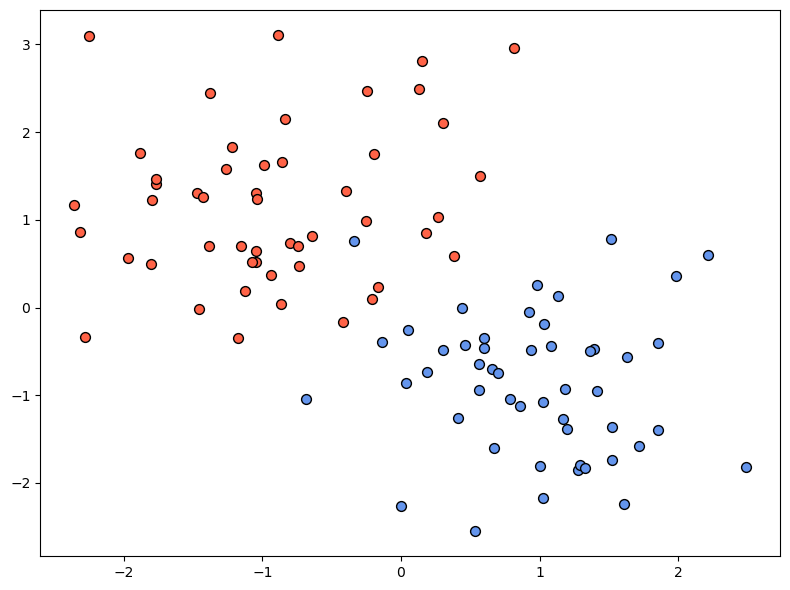

In [4]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

class TwoClassDataset(Dataset):
    # don't forget the self identifier!
    def __init__(self, N, sigma):
        self.N = N # number of data points per class
        self.sigma = sigma # standard deviation of each class cluster
        self.plus_class = self.sigma*torch.randn(N, 2) + torch.tensor([-1, 1])
        self.negative_class = self.sigma*torch.randn(N, 2) + torch.tensor([1, -1])
        self.data = torch.cat((self.plus_class, self.negative_class), dim=0)
        self.labels = torch.cat((torch.ones(self.N), torch.zeros(self.N)))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y # return input and output pair

N = 50
sigma = 0.75
dataset = TwoClassDataset(N, sigma)

plus_data = dataset.plus_class
negative_data = dataset.negative_class
print('Dataset has {} points'.format(len(dataset)))
idx = 2
x, y = dataset[idx]
print('Dataset point with index {} is at x={} and label y={}'.format(idx, x, y))
plt.figure(figsize=(8, 6))
plt.scatter(plus_data[:, 0].numpy(), plus_data[:, 1].numpy(), color='tomato', s=50, edgecolor='black')
plt.scatter(negative_data[:, 0].numpy(), negative_data[:, 1].numpy(), color='cornflowerblue', s=50, edgecolor='black')
plt.tight_layout()

Aside from making custom datasets, PyTorch and torchvision have [many pre-loaded datasets](https://pytorch.org/vision/stable/datasets.html) implemented within the same ``Dataset`` interface.

## PyTorch Dataloaders

With a PyTorch ``Dataset`` class in hand, we may take advantage of the ``torch.utils.data.DataLoader`` interface that will simplify the process of sampling batches of data; shuffling the dataset; partitioning into training set, validation set, testing set; and more! A ``DataLoader`` does not need to be implemented like a ``Dataset`` or ``nn.Module`` class. Instead, we only need to provide a ``Dataset`` object as input alongside several optional inputs:
* ``batch_size``: number of examples in each batch or call to the dataloader

* ``shuffle``: Boolean option to shuffle dataset each pass or **epoch** through the dataset

* ``sampler``: ``Sampler`` object that specifies how data will be extracted from the dataset. For example, the ``SubsetRandomSampler`` allows us to specify indices within the larger dataset to sample at random. This is an easy way to create training, validation, and testing sets!

* Plenty other options that [may be explored here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [5]:
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

# create indices for each split of dataset
N_train = 60
N_val = 20
N_test = 20
indices = np.arange(len(dataset))
np.random.shuffle(indices)
train_indices = indices[:N_train]
val_indices = indices[N_train:N_train+N_val]
test_indices = indices[N_train+N_val:]

# create dataloader for each split
batch_size = 8
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_indices))

# data loaders are iterable
for x_batch, y_batch in val_loader:
    print(x_batch, y_batch)

tensor([[ 1.5232, -1.7344],
        [ 2.4897, -1.8220],
        [ 0.9822,  0.2559],
        [ 0.8586, -1.1223],
        [-0.3398,  0.7563],
        [ 0.9224, -0.0509],
        [ 0.2688,  1.0283],
        [-1.0448,  0.5194]]) tensor([0., 0., 0., 0., 0., 0., 1., 1.])
tensor([[-1.9689,  0.5689],
        [ 0.3820,  0.5833],
        [ 1.0813, -0.4420],
        [-0.1367, -0.3974],
        [ 2.2098,  0.5979],
        [-2.3582,  1.1711],
        [-0.6862, -1.0419],
        [ 1.2758, -1.8508]]) tensor([1., 1., 0., 0., 0., 1., 0., 0.])
tensor([[ 0.5595, -0.9409],
        [-0.8874,  3.1101],
        [ 1.1972, -1.3878],
        [-1.1763, -0.3457]]) tensor([0., 1., 0., 1.])


## The New and Improved Training Loop

Now, let's combine these datasets and dataloaders to further simplify the training loop we used to perform the toy logistic regression problem in the previous lecture.

In [6]:
# code from previous lecture
import torch.nn as nn

class LogisticRegression(nn.Module):
    def __init__(self, N):
        super().__init__()
        self.w = nn.Parameter(torch.ones(N))
        self.b = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return 1/(1+torch.exp(-(self.w@x+self.b)))

# compute classification accuracy
def model_accuracy(model, input_data, labels):
    predictions = model(input_data.unsqueeze(-1)).squeeze(-1)
    positive_preds = predictions >= 0.5
    negative_preds = predictions < 0.5
    n_correct = torch.sum(positive_preds*labels)+torch.sum(negative_preds*(1-labels))
    return n_correct

Text(0.5, 0, 'Epoch')

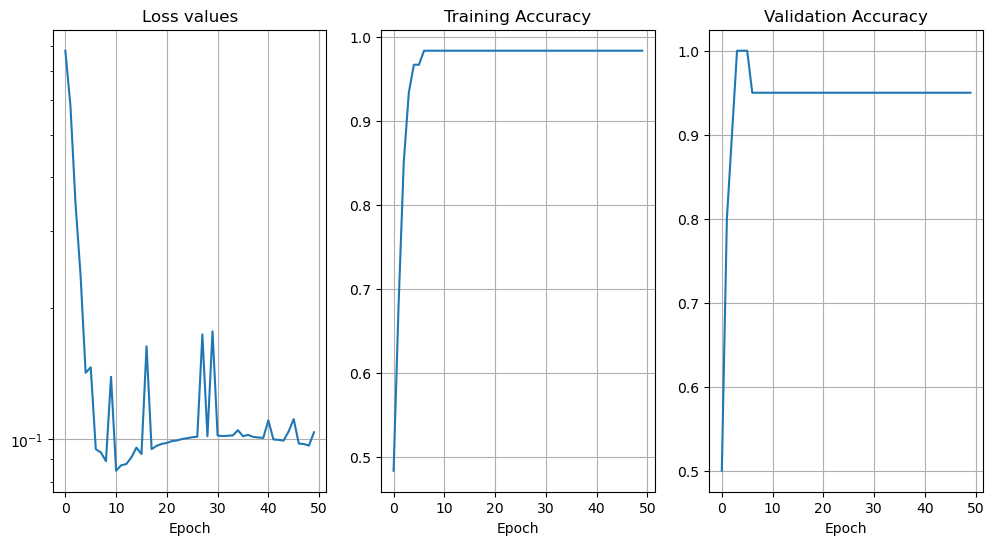

In [7]:
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

# create indices for each split of dataset
N_train = 60
N_val = 20
N_test = 20
indices = np.arange(len(dataset))
np.random.shuffle(indices)
train_indices = indices[:N_train]
val_indices = indices[N_train:N_train+N_val]
test_indices = indices[N_train+N_val:]

# create dataloader for each split
batch_size = 8
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_indices))

# training setup
criterion = nn.BCELoss(reduction='mean') # binary cross-entropy loss, use mean loss
lr = 1e-2 # learning rate
logreg_model = LogisticRegression(2) # initialize model
optimizer = torch.optim.SGD(logreg_model.parameters(), lr=lr, momentum=0.99, weight_decay=1e-3) # initialize optimizer

n_epoch = 50 # number of passes through the training dataset
loss_values, train_accuracies, val_accuracies = [], [], []
for n in range(n_epoch):
    epoch_loss, epoch_acc = 0, 0
    for x_batch, y_batch in train_loader:
        # zero out gradients
        optimizer.zero_grad()
        # pass batch to model
        predictions = logreg_model(x_batch.unsqueeze(-1)).squeeze(-1) # make dimensions match for loss function
        # calculate loss
        loss = criterion(predictions, y_batch)
        # backpropagate and update
        loss.backward()
        optimizer.step()
        # logging
        epoch_loss += loss.item()
        epoch_acc += model_accuracy(logreg_model, x_batch, y_batch)
    loss_values.append(epoch_loss/len(train_loader))
    train_accuracies.append(epoch_acc/N_train)
    # validation performance
    val_acc = 0
    for x_batch, y_batch in val_loader:
        # don't compute gradients since we are only evaluating the model
        with torch.no_grad():
            val_acc += model_accuracy(logreg_model, x_batch, y_batch)
    val_accuracies.append(val_acc/N_val)

plt.figure(figsize=(12,6))
plt.subplot(131)
plt.semilogy(loss_values)
plt.grid(True)
plt.title('Loss values')
plt.xlabel('Epoch')
plt.subplot(132)
plt.plot(train_accuracies)
plt.grid(True)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.subplot(133)
plt.plot(val_accuracies)
plt.grid(True)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')

## Multi-class Logistic Regression

Recall from our lecture on multi-class logistic regression that we may perform multi-class classification using logistic regression where each class has its own weight vector and bias term. More formally, for class $k$, we have weight vector $w_k\in\mathbb{R}^n$ and bias $b_k\in\mathbb{R}$. Thus, an input $x\in\mathbb{R}^n$ receives a "score" $z_k$ for class $k$ via
$$
z_k = w_k^\top x + b_k.
$$

Larger scores should correspond to larger probabilities for a particular class while smaller (possibly negative) scores give smaller probabilities. For a collection of scores $z=\{z_1, z_2, \ldots, z_M\}$ across $M$ classes, we can use the softmax function to normalize these scores to a probability distribution.

$$
\textrm{softmax}(z)_k=\mathbf{Pr}\{\textrm{Class }y=k|x\} = \frac{e^{z_k}}{\sum_{j=1}^{M}e^{z_j}}.
$$

Instead of computing each score one-by-one, we can put all of our parameters into a weight matrix $A$ with a bias vector $b$. Thus,

$$
\begin{align}
z &= Ax+b\\
&= \begin{bmatrix}
\rule[.6ex]{4ex}{0.75pt} & w_1^\top & \rule[.6ex]{4ex}{0.75pt}\\
\rule[.6ex]{4ex}{0.75pt} & w_2^\top & \rule[.6ex]{4ex}{0.75pt}\\
& \vdots & \\
\rule[.6ex]{4ex}{0.75pt} & w_M^\top & \rule[.6ex]{4ex}{0.75pt}\\
\end{bmatrix}\begin{bmatrix}
\rule[-1ex]{0.5pt}{4ex}\\
x\\
\rule[1ex]{0.5pt}{4ex}\\
\end{bmatrix}
+\begin{bmatrix}
b_1\\
b_2\\
\vdots\\
b_M
\end{bmatrix}\\
&= \begin{bmatrix}
z_1\\
z_2\\
\vdots\\
z_M
\end{bmatrix}
\end{align}
$$

In PyTorch, we can efficiently implement the multi-class logistic regression model using the [``nn.Linear`` class](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) which implements parameter matrices including bias terms. For the below implementation, we will also not apply the softmax function ourselves since the ``nn.CrossEntropyLoss`` class expects **logits** or scores instead of the final probabilities.

In [8]:
class MulticlassLogisticRegression(nn.Module):
    def __init__(self, N, M):
        super().__init__()
        self.N = N # input dimension
        self.M = M # number of classes
        self.weight_matrix = nn.Linear(N, M, bias=True) # N input dimensions, M output dimensions

    def forward(self, x):
        return self.weight_matrix(x)

And that's it! Again, we could compute the softmax of these logits/scores but the PyTorch implementation of cross-entropy loss asks for logits instead of probabilities. Finally, recall for model $f_\theta(x)=z$ that cross-entropy loss is given by
$$
\ell_{ce}(f_\theta(x), y) = -\log\left(\textrm{softmax}(f_\theta(x))_y\right)= -\log\left(\frac{e^{z_y}}{\sum_{j=1}^{M}e^{z_j}}\right)
$$
for input $x$ with label $y$ (assume class number $y$ also identifies the appropriate index in $z$, for simplicity).

## Lecture Exercise: Toy Multi-class Logistic Regression

Below, we provide a toy dataset for generating a toy 4-class dataset with $N=50$ samples per class and $\sigma=0.6$.

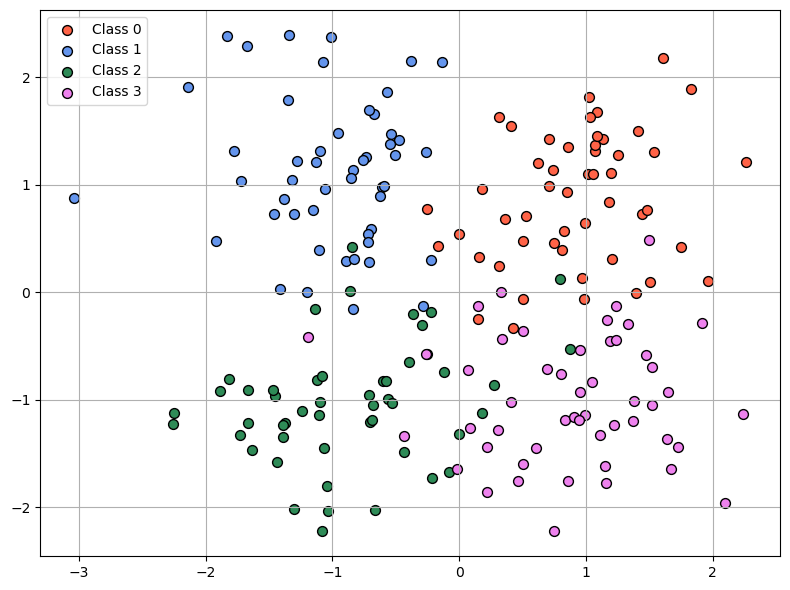

In [18]:
import torch

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

class FourClassDataset(Dataset):
    def __init__(self, N, sigma):
        self.N = N # number of data points per class
        self.sigma = sigma # standard deviation of each class cluster
        self.class_zero = self.sigma*torch.randn(N, 2) + torch.tensor([1, 1])
        self.class_one = self.sigma*torch.randn(N, 2) + torch.tensor([-1, 1])
        self.class_two = self.sigma*torch.randn(N, 2) + torch.tensor([-1, -1])
        self.class_three = self.sigma*torch.randn(N, 2) + torch.tensor([1, -1])
        self.data = torch.cat((self.class_zero, self.class_one, self.class_two, self.class_three), dim=0)
        self.labels = torch.cat((torch.zeros(self.N), torch.ones(self.N),
                                 2*torch.ones(self.N), 3*torch.ones(self.N))).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y # return input and output pair

# visualize dataset
N = 50
sigma = 0.6
dataset = FourClassDataset(N, sigma)
class_zero = dataset.class_zero
class_one = dataset.class_one
class_two = dataset.class_two
class_three = dataset.class_three
plt.figure(figsize=(8, 6))
plt.scatter(class_zero[:, 0].numpy(), class_zero[:, 1].numpy(), color='tomato', s=50, edgecolor='black', label='Class 0')
plt.scatter(class_one[:, 0].numpy(), class_one[:, 1].numpy(), color='cornflowerblue', s=50, edgecolor='black', label='Class 1')
plt.scatter(class_two[:, 0].numpy(), class_two[:, 1].numpy(), color='seagreen', s=50, edgecolor='black', label='Class 2')
plt.scatter(class_three[:, 0].numpy(), class_three[:, 1].numpy(), color='violet', s=50, edgecolor='black', label='Class 3')
plt.grid(True)
plt.legend()
plt.tight_layout()

a) Create training, validation, and testing dataloaders with a 60%:20%:20% training:validation:testing split and batch size 16.

b) Fill in the training loop for training the ``MulticlassLogisticRegression`` model using the ``nn.CrossEntropyLoss`` function. We have provided the helper function for tracking model accuracy and comments below to help. **Note:** we do not need to worry about the squeezing and unsqueezing of the last dimension when passing data to the model now that we are using the ``nn.Linear`` class for our parameters.

c) Experiment with training parameters, e.g. learning rate, number of epochs, batch size, momentum, weight decay, and plot the training loss, training accuracy, and validation accuracy.

d) Observe the performance of this multi-class logistic regression model with noisier clusters, i.e. bigger values of $\sigma$.

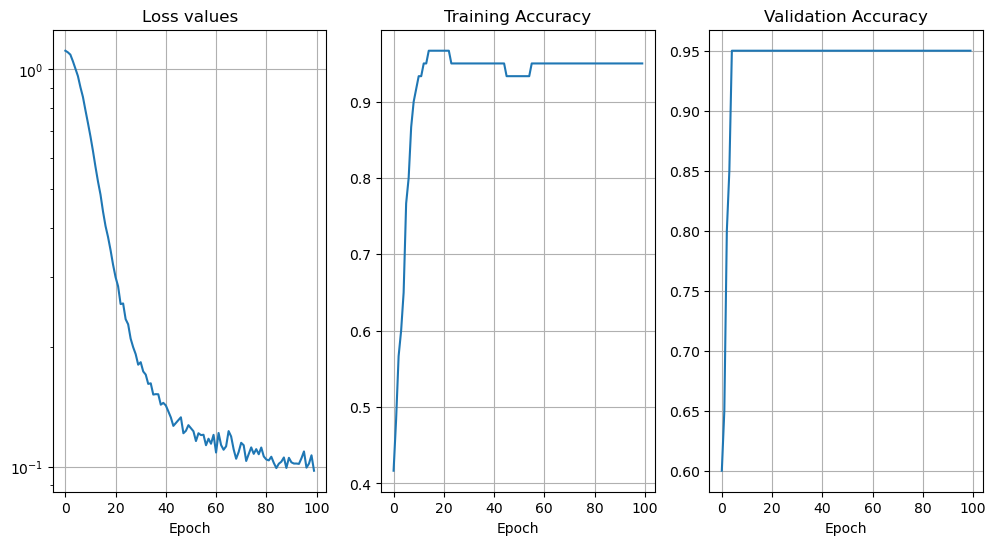

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt


def multiclass_model_accuracy(model, input_data, labels):
    predictions = model(input_data)  # no need to squeeze/unsqueeze dimensions now!
    predicted_classes = torch.argmax(predictions, dim=1)  # find highest scoring class along the columns
    n_correct = torch.sum(torch.eq(predicted_classes, labels))
    return n_correct.item()

# Part a) create DataLoaders
# Assuming 'dataset' is already defined
n_total = 100
n_train = 60
n_val = 20
n_test = 20
batch_size = 16

# Generate indices and shuffle them
indices = np.arange(n_total)
np.random.shuffle(indices)

# Split indices for training, validation, and test sets
train_indices = indices[:n_train]
val_indices = indices[n_train:n_train + n_val]
test_indices = indices[n_train + n_val:]

# Create data loaders with SubsetRandomSampler
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_indices))

# Part b) training loop
# initialize MulticlassLogisticRegression model
N = 2
M = 4
logreg_model = MulticlassLogisticRegression(N,M)  # initialize model
# initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
lr = 1e-3  # learning rate
optimizer = optim.SGD(logreg_model.parameters(), lr=lr, momentum=0.99, weight_decay=1e-3)  # initialize optimizer

# logging info
loss_values, train_accuracies, val_accuracies = [], [], []
n_epoch = 100  # set this value
for n in range(n_epoch):
    epoch_loss, epoch_acc = 0, 0
    for x_batch, y_batch in train_loader:
        # zero out gradients
        optimizer.zero_grad()
        # pass batch to model, no need to worry about using squeeze/unsqueeze now
        predictions = logreg_model(x_batch)
        # calculate loss
        loss = criterion(predictions, y_batch)
        # backpropagate and update
        loss.backward()
        optimizer.step()
        # logging to update epoch_loss (add loss value) and epoch_acc (add current batch accuracy)
        epoch_loss += loss.item()
        epoch_acc += multiclass_model_accuracy(logreg_model, x_batch, y_batch)

    loss_values.append(epoch_loss / len(train_loader))
    train_accuracies.append(epoch_acc / n_train)
    # validation performance
    val_acc = 0
    for x_batch, y_batch in val_loader:
        # don't compute gradients since we are only evaluating the model
        with torch.no_grad():
            # validation batch accuracy
            val_acc += multiclass_model_accuracy(logreg_model, x_batch, y_batch)
    val_accuracies.append(val_acc / n_val)

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.semilogy(loss_values)
plt.grid(True)
plt.title('Loss values')
plt.xlabel('Epoch')
plt.subplot(132)
plt.plot(train_accuracies)
plt.grid(True)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.subplot(133)
plt.plot(val_accuracies)
plt.grid(True)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.show()

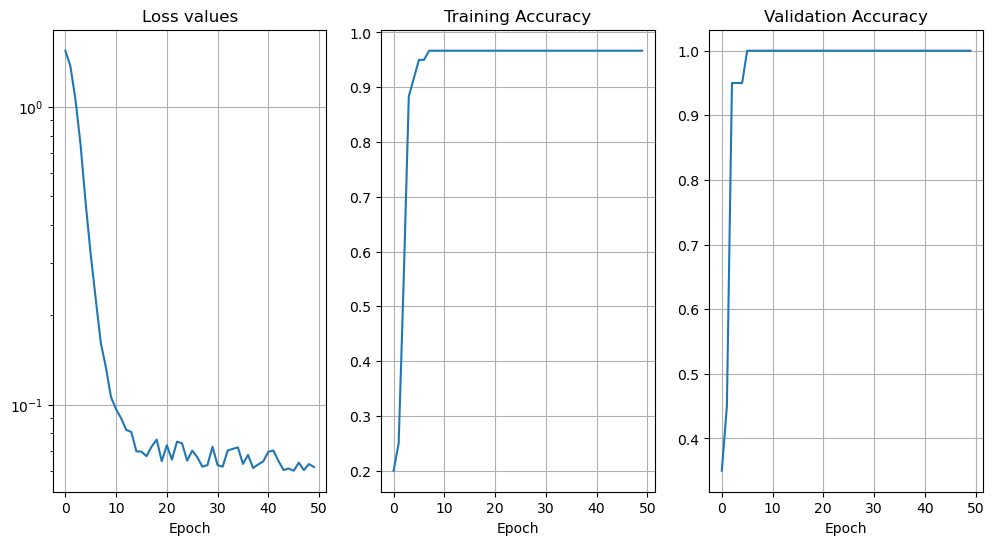

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt

# Define the LogisticRegression model if not already defined
class LogisticRegression(nn.Module):
    def __init__(self, input_dim,output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)  # Assuming 4 classes for multiclass classification

    def forward(self, x):
        return self.linear(x)

def multiclass_model_accuracy(model, input_data, labels):
    predictions = model(input_data)  # no need to squeeze/unsqueeze dimensions now!
    predicted_classes = torch.argmax(predictions, dim=1)  # find highest scoring class along the columns
    n_correct = torch.sum(torch.eq(predicted_classes, labels))
    return n_correct.item()

# Part a) create DataLoaders
# Assuming 'dataset' is already defined
n_total = 100
n_train = 60
n_val = 20
n_test = 20
batch_size = 16

# Generate indices and shuffle them
indices = np.arange(n_total)
np.random.shuffle(indices)

# Split indices for training, validation, and test sets
train_indices = indices[:n_train]
val_indices = indices[n_train:n_train + n_val]
test_indices = indices[n_train + n_val:]

# Create data loaders with SubsetRandomSampler
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_indices))

# Part b) training loop
# initialize MulticlassLogisticRegression model
N = 2
M = 4

# initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
lr = 1e-2  # learning rate
logreg_model = LogisticRegression(N,M)  # initialize model
optimizer = optim.SGD(logreg_model.parameters(), lr=lr, momentum=0.99, weight_decay=1e-3)  # initialize optimizer

# logging info
loss_values, train_accuracies, val_accuracies = [], [], []
n_epoch = 50  # set this value
for n in range(n_epoch):
    epoch_loss, epoch_acc = 0, 0
    for x_batch, y_batch in train_loader:
        # zero out gradients
        optimizer.zero_grad()
        # pass batch to model, no need to worry about using squeeze/unsqueeze now
        predictions = logreg_model(x_batch)
        # calculate loss
        loss = criterion(predictions, y_batch)
        # backpropagate and update
        loss.backward()
        optimizer.step()
        # logging to update epoch_loss (add loss value) and epoch_acc (add current batch accuracy)
        epoch_loss += loss.item()
        epoch_acc += multiclass_model_accuracy(logreg_model, x_batch, y_batch)

    loss_values.append(epoch_loss / len(train_loader))
    train_accuracies.append(epoch_acc / n_train)
    # validation performance
    val_acc = 0
    for x_batch, y_batch in val_loader:
        # don't compute gradients since we are only evaluating the model
        with torch.no_grad():
            # validation batch accuracy
            val_acc += multiclass_model_accuracy(logreg_model, x_batch, y_batch)
    val_accuracies.append(val_acc / n_val)

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.semilogy(loss_values)
plt.grid(True)
plt.title('Loss values')
plt.xlabel('Epoch')
plt.subplot(132)
plt.plot(train_accuracies)
plt.grid(True)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.subplot(133)
plt.plot(val_accuracies)
plt.grid(True)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.show()

In [20]:
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler

# Assuming 'dataset' is already defined
n_total = 100
n_train = 60
n_val = 20
n_test = 20
batch_size = 16

# Generate indices and shuffle them
indices = np.arange(n_total)
np.random.shuffle(indices)

# Split indices for training, validation, and test sets
train_indices = indices[:n_train]
val_indices = indices[n_train:n_train + n_val]
test_indices = indices[n_train + n_val:]

# Create data loaders with SubsetRandomSampler
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_indices))

In [21]:
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler

# Assuming 'dataset' is already defined
n_total = 100
n_train = 60
n_val = 20
n_test = 20
batch_size = 16

# Generate indices and shuffle them
indices = np.arange(n_total)
np.random.shuffle(indices)

# Split indices for training, validation, and test sets
train_indices = indices[:n_train]
val_indices = indices[n_train:n_train + n_val]
test_indices = indices[n_train + n_val:]

# Create data loaders with SubsetRandomSampler
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_indices))